# Build with Mixtral-8x7B-Instruct-v0.1 & Haystack

_Colab by Tuana Celik - ([LI](https://www.linkedin.com/in/tuanacelik/) & [Twitter](https://twitter.com/tuanacelik))_


Quick guide to building with the new `Mixtral-8x7B-Instruct-v0.1` model by Mistral AI.


**Why is Mixtral different?**

This is quite a cool new model. It's the first of its kind as an open-source model in that it is a _mixture_ (get _Mix_ tral) of 8 7B parameter models. This [article on Hugging Face](https://huggingface.co/blog/moe) describes this phenomenon way better and in way more detail than I can. The idea is that it's a mixture of 8 different "experts", with a router that routes a query to a given expert (not entirely accurate, but a good way to simplify). This means not all 8 models are inferenced, making it remarkably fast too!



1. Use the [`HuggingFaceAPIChatGenerator`](https://docs.haystack.deepset.ai/docs/huggingfaceapichatgenerator) to query the model on its own
2. Add the generator to a full RAG Pipeline (on the web)


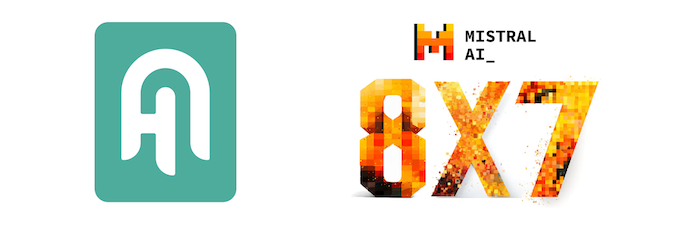
### Install dependencies

In [1]:
!uv pip install haystack-ai trafilatura sentence_transformers "huggingface_hub>=0.22.0"

Using Python 3.12.6 environment at: /Users/dsbatista/haystack-cookbook/.venv
Resolved 70 packages in 813ms                                        
Prepared 2 packages in 444ms                                             
Uninstalled 1 package in 147ms
Installed 10 packages in 111ms                              
 + courlan==1.3.2
 + dateparser==1.2.2
 + htmldate==1.9.3
 + justext==3.0.2
 + lxml==5.4.0
 + lxml-html-clean==0.4.2
 - sympy==1.14.0
 + sympy==1.13.1
 + tld==0.13.1
 + trafilatura==2.0.0
 + tzlocal==5.3.1


## Prompt the Model - Standalone

We are using Hugging Face Serverless Inference API.

- This requires an API key: https://huggingface.co/settings/tokens
- You should also accept Mistral conditions here: https://huggingface.co/mistralai/Mixtral-8x7B-Instruct-v0.1


In [3]:
import os
from getpass import getpass

os.environ["HF_API_TOKEN"] = getpass("Enter Hugging Face token: ")

Enter Hugging Face token:  ········


In [ ]:
from haystack.components.generators.chat import HuggingFaceAPIChatGenerator

generator = HuggingFaceAPIChatGenerator(
    api_type="serverless_inference_api",
    api_params={"model": "mistralai/Mixtral-8x7B-Instruct-v0.1"}
)

In [ ]:
from haystack.dataclasses import ChatMessage

messages = [
    ChatMessage.from_system("\\nYou are a helpful, respectful and honest assistant"),
    ChatMessage.from_user("What's Natural Language Processing?")
]

result = generator.run(messages)
print(result["replies"][0].text)

 Natural Language Processing, often abbreviated as NLP, is a branch of artificial intelligence that focuses on the interaction between computers and humans through natural language. The ultimate objective of NLP is to read, decipher, understand, and make sense of the human language in a valuable way.

NLP involves several complex tasks such as language understanding, language generation, translation, and speech recognition. It's used in many applications we use daily, including search engines, voice-activated assistants, and automated customer service bots. 

By analyzing and interpreting human language, NLP enables machines to understand and respond to text or voice inputs in a way that's similar to how humans communicate. However, it's important to note that NLP technology still has limitations and is not perfect, but it's continually improving with advancements in machine learning and artificial intelligence.


## Use the Model in a full RAG pipeline (on the web)

Here, we will be using the same `generator` component as the above, in a full RAG pipeline. You can change this pipeline to use your own data source (such as a vector databse, Notion, documentation) instead of the [`LinkContentFetcher`](https://docs.haystack.deepset.ai/docs/linkcontentfetcher) we are using here.

In [8]:
from haystack.components.fetchers.link_content import LinkContentFetcher
from haystack.components.converters import HTMLToDocument
from haystack.components.preprocessors import DocumentSplitter
from haystack.components.rankers import TransformersSimilarityRanker
from haystack.components.builders.chat_prompt_builder import ChatPromptBuilder
from haystack import Pipeline

fetcher = LinkContentFetcher()
converter = HTMLToDocument()
document_splitter = DocumentSplitter(split_by="word", split_length=50)
similarity_ranker = TransformersSimilarityRanker(top_k=3)

prompt_template = """
According to these documents:

{% for doc in documents %}
  {{ doc.content }}
{% endfor %}

Answer the given question: {{question}}
Answer:
"""

prompt_template = [ChatMessage.from_user(prompt_template)]
prompt_builder = ChatPromptBuilder(template=prompt_template)

pipeline = Pipeline()
pipeline.add_component("fetcher", fetcher)
pipeline.add_component("converter", converter)
pipeline.add_component("splitter", document_splitter)
pipeline.add_component("ranker", similarity_ranker)
pipeline.add_component("prompt_builder", prompt_builder)
pipeline.add_component("llm", generator)

pipeline.connect("fetcher.streams", "converter.sources")
pipeline.connect("converter.documents", "splitter.documents")
pipeline.connect("splitter.documents", "ranker.documents")
pipeline.connect("ranker.documents", "prompt_builder.documents")
pipeline.connect("prompt_builder.prompt", "llm")

TransformersSimilarityRanker is considered legacy and will no longer receive updates. It may be deprecated in a future release, with removal following after a deprecation period. Consider using SentenceTransformersSimilarityRanker instead, which provides the same functionality along with additional features.
ChatPromptBuilder has 2 prompt variables, but `required_variables` is not set. By default, all prompt variables are treated as optional, which may lead to unintended behavior in multi-branch pipelines. To avoid unexpected execution, ensure that variables intended to be required are explicitly set in `required_variables`.


🚅 Components
  - fetcher: LinkContentFetcher
  - converter: HTMLToDocument
  - splitter: DocumentSplitter
  - ranker: TransformersSimilarityRanker
  - prompt_builder: ChatPromptBuilder
  - llm: HuggingFaceAPIChatGenerator
🛤️ Connections
  - fetcher.streams -> converter.sources (List[ByteStream])
  - converter.documents -> splitter.documents (List[Document])
  - splitter.documents -> ranker.documents (List[Document])
  - ranker.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> llm.messages (List[ChatMessage])

In [9]:
question = "What do graphs have to do with Haystack?"
result = pipeline.run({"prompt_builder": {"question": question},
                   "ranker": {"query": question},
                   "fetcher": {"urls": ["https://haystack.deepset.ai/blog/introducing-haystack-2-beta-and-advent"]},
                    "llm":{}})

print(result['llm']['replies'][0])

ChatMessage(_role=<ChatRole.ASSISTANT: 'assistant'>, _content=[TextContent(text=' Based on the information provided, graphs, specifically directed acyclic graphs (DAGs), are relevant to the earlier version of Haystack, version 1.x, as the pipeline components were organized in a DAG structure, which meant that the pipeline had to be acyclic and directed, and could not branch out, join, or cycle back to another component. However, with Haystack 2.0, the requirement for the pipeline to be acyclic is being removed, allowing for more complex and flexible pipeline configurations, such as pipelines that can retry, loop back, and potentially cycle back to another component. This change will make the framework better suited to a wider range of use cases and make the code more explicit and self-explanatory.')], _name=None, _meta={'model': 'mistralai/Mixtral-8x7B-Instruct-v0.1', 'finish_reason': 'stop', 'index': 0, 'usage': {'prompt_tokens': 268, 'completion_tokens': 156}})
